Starting simulation at t=0. s for a duration of 4. s
2.8776 s (71%) simulated in 10s, estimated 4s remaining.
4. s (100%) simulated in 13s
Profiling summary
popE_stateupdater                                   1.64 s    14.10 %
poissoninput                                        1.14 s     9.80 %
C_EE_AMPA_pre                                       0.66 s     5.63 %
popI_stateupdater                                   0.59 s     5.05 %
ratemonitor                                         0.59 s     5.04 %
NMDA_set_total_E_summed_variable_s_NMDA_tot_post    0.48 s     4.10 %
C_IE_pre                                            0.47 s     4.01 %
ratemonitor_1                                       0.43 s     3.72 %
poissoninput_1                                      0.41 s     3.56 %
C_stimE1_pre                                        0.39 s     3.36 %
NMDA_sum_summed_variable_s_post                     0.38 s     3.30 %
spikemonitor                                        0.38 s     3.24 %
C_s

INFO       width adjusted from 100. ms to 100.1 ms [brian2.monitors.ratemonitor.adjusted_width]


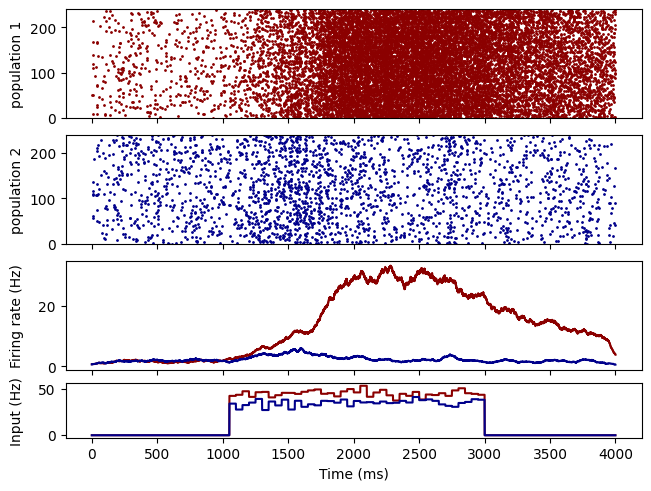

In [1]:
from brian2 import *

# -----------------------------------------------------------------------------------------------
# Set up the simulation
# -----------------------------------------------------------------------------------------------

# Stimulus and simulation parameters
coh = 12.8  # coherence of random dots
sigma = 4.0 * Hz  # standard deviation of stimulus input
mu0 = 40.0 * Hz  # stimulus input at zero coherence
mu1 = 40.0 * Hz  # selective stimulus input at highest coherence
stim_interval = 50.0 * ms  # stimulus changes every 50 ms
stim_on = 1000 * ms  # stimulus onset
stim_off = 3000 * ms  # stimulus offset
runtime = 4000 * ms  # total simulation time

# External noise inputs
N_ext = 1000  # number of external Poisson neurons
rate_ext_E = 2400 * Hz / N_ext  # external Poisson rate for excitatory population
rate_ext_I = 2400 * Hz / N_ext  # external Poisson rate for inhibitory population

# Network parameters
N = 2000  # number of neurons
f_inh = 0.2  # fraction of inhibitory neurons
NE = int(N * (1.0 - f_inh))  # number of excitatory neurons (1600)
NI = int(N * f_inh)  # number of inhibitory neurons (400)
fE = 0.15  # coding fraction
subN = int(fE * NE)  # number of neurons in decision pools (240)

# Neuron parameters
El = -70.0 * mV  # resting potential
Vt = -50.0 * mV  # firing threshold
Vr = -55.0 * mV  # reset potential
CmE = 0.5 * nF  # membrane capacitance for pyramidal cells (excitatory neurons)
CmI = 0.2 * nF  # membrane capacitance for interneurons (inhibitory neurons)
gLeakE = 25.0 * nS  # membrane leak conductance of excitatory neurons
gLeakI = 20.0 * nS  # membrane leak conductance of inhibitory neurons
refE = 2.0 * ms  # refractory periodof excitatory neurons
refI = 1.0 * ms  # refractory period of inhibitory neurons

# Synapse parameters
V_E = 0. * mV  # reversal potential for excitatory synapses
V_I = -70. * mV  # reversal potential for inhibitory synapses
tau_AMPA = 2.0 * ms  # AMPA synapse decay
tau_NMDA_rise = 2.0 * ms  # NMDA synapse rise
tau_NMDA_decay = 100.0 * ms  # NMDA synapse decay
tau_GABA = 5.0 * ms  # GABA synapse decay
alpha = 0.5 * kHz  # saturation of NMDA channels at high presynaptic firing rates
C = 1 * mmole  # extracellular magnesium concentration

# Synaptic conductances
gextE = 2.1 * nS  # external -> excitatory neurons (AMPA)
gextI = 1.62 * nS  # external -> inhibitory neurons (AMPA)
gEEA = 0.05 * nS / NE * 1600  # excitatory -> excitatory neurons (AMPA)
gEIA = 0.04 * nS / NE * 1600  # excitatory -> inhibitory neurons (AMPA)
gEEN = 0.165 * nS / NE * 1600  # excitatory -> excitatory neurons (NMDA)
gEIN = 0.13 * nS / NE * 1600  # excitatory -> inhibitory neurons (NMDA)
gIE = 1.3 * nS / NI * 400  # inhibitory -> excitatory neurons (GABA)
gII = 1.0 * nS / NI * 400  # inhibitory -> inhibitory neurons (GABA)

# Synaptic footprints
Jp = 1.7  # relative synaptic strength inside a selective population (1.0: no potentiation))
Jm = 1.0 - fE * (Jp - 1.0) / (1.0 - fE)

# Neuron equations
# Note the "(unless refractory)" statement serves to clamp the membrane voltage during the refractory period;
# otherwise the membrane potential continues to be integrated but no spikes are emitted.
eqsE = """
   label : integer (constant)  # label for decision encoding populations
   dV/dt = (- gLeakE * (V - El) - I_AMPA - I_NMDA - I_GABA - I_AMPA_ext + I_input) / CmE : volt (unless refractory)

   I_AMPA = s_AMPA * (V - V_E) : amp
   ds_AMPA / dt = - s_AMPA / tau_AMPA : siemens

   I_NMDA = gEEN * s_NMDA_tot * (V - V_E) / ( 1 + exp(-0.062 * V/mvolt) * (C/mmole / 3.57) ) : amp
   s_NMDA_tot : 1

   I_GABA = s_GABA * (V - V_I) : amp
   ds_GABA / dt = - s_GABA / tau_GABA : siemens

   I_AMPA_ext = s_AMPA_ext * (V - V_E) : amp
   ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : siemens

   I_input : amp

   ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1
   dx / dt = - x / tau_NMDA_rise : 1
"""

eqsI = """
   dV/dt = (- gLeakI * (V - El) - I_AMPA - I_NMDA - I_GABA - I_AMPA_ext) / CmI : volt (unless refractory)

   I_AMPA = s_AMPA * (V - V_E) : amp
   ds_AMPA / dt = - s_AMPA / tau_AMPA : siemens

   I_NMDA = gEIN * s_NMDA_tot * (V - V_E) / ( 1 + exp(-0.062 * V/mvolt) * (C/mmole / 3.57) ): amp
   s_NMDA_tot : 1

   I_GABA = s_GABA * (V - V_I) : amp
   ds_GABA / dt = - s_GABA / tau_GABA : siemens

   I_AMPA_ext = s_AMPA_ext * (V - V_E) : amp
   ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : siemens
"""

# Neuron populations
popE = NeuronGroup(NE, model=eqsE, threshold='V > Vt', reset='V = Vr', refractory=refE, method='euler', name='popE')
popI = NeuronGroup(NI, model=eqsI, threshold='V > Vt', reset='V = Vr', refractory=refI, method='euler', name='popI')
popE1 = popE[:subN]
popE2 = popE[subN:2 * subN]
popE3 = popE[2 * subN:]
popE1.label = 0
popE2.label = 1
popE3.label = 2

# Recurrent excitatory -> excitatory connections mediated by AMPA receptors
C_EE_AMPA = Synapses(popE, popE, 'w : siemens', on_pre='s_AMPA += w', delay=0.5 * ms, method='euler', name='C_EE_AMPA')
C_EE_AMPA.connect()
C_EE_AMPA.w[:] = gEEA
C_EE_AMPA.w["label_pre == label_post and label_pre < 2"] = gEEA*Jp
C_EE_AMPA.w["label_pre != label_post and label_post < 2"] = gEEA*Jm
# Note that this produces the following structure of excitatory connections:
#
#        | from E1  from E2  from E3
#  ---------------------------------
#  to E1 |   Jp      Jm       Jm
#  to E2 |   Jm      Jp       Jm
#  to E3 |    1       1        1

# Recurrent excitatory -> inhibitory connections mediated by AMPA receptors
C_EI_AMPA = Synapses(popE, popI, on_pre='s_AMPA += gEIA', delay=0.5 * ms, method='euler', name='C_EI_AMPA')
C_EI_AMPA.connect()

# Recurrent excitatory -> excitatory connections mediated by NMDA receptors
C_EE_NMDA = Synapses(popE, popE, on_pre='x_pre += 1', delay=0.5 * ms, method='euler', name='C_EE_NMDA')
C_EE_NMDA.connect(j='i')

# Dummy population to store the summed activity of the three populations
NMDA_sum_group = NeuronGroup(3, 's : 1', name='NMDA_sum_group')

# Sum the activity according to the subpopulation labels
NMDA_sum = Synapses(popE, NMDA_sum_group, 's_post = s_NMDA_pre : 1 (summed)', name='NMDA_sum')
NMDA_sum.connect(j='label_pre')

# Propagate the summed activity to the NMDA synapses
NMDA_set_total_E = Synapses(NMDA_sum_group, popE,
                            '''w : 1 (constant)
                               s_NMDA_tot_post = w*s_pre : 1 (summed)''', name='NMDA_set_total_E')
NMDA_set_total_E.connect()
NMDA_set_total_E.w = 1
NMDA_set_total_E.w["i == label_post and label_post < 2"] = Jp
NMDA_set_total_E.w["i != label_post and label_post < 2"] = Jm

# Recurrent excitatory -> inhibitory connections mediated by NMDA receptors
NMDA_set_total_I = Synapses(NMDA_sum_group, popI,
                            '''s_NMDA_tot_post = s_pre : 1 (summed)''', name='NMDA_set_total_I')
NMDA_set_total_I.connect()

# Recurrent inhibitory -> excitatory connections mediated by GABA receptors
C_IE = Synapses(popI, popE, on_pre='s_GABA += gIE', delay=0.5 * ms, method='euler', name='C_IE')
C_IE.connect()

# Recurrent inhibitory -> inhibitory connections mediated by GABA receptors
C_II = Synapses(popI, popI, on_pre='s_GABA += gII', delay=0.5 * ms, method='euler', name='C_II')
C_II.connect()

# External inputs (fixed background firing rates)
extinputE = PoissonInput(popE, 's_AMPA_ext', N_ext, rate_ext_E, gextE)
extinputI = PoissonInput(popI, 's_AMPA_ext', N_ext, rate_ext_I, gextI)

# Stimulus input (updated every 50ms)
stiminputE1 = PoissonGroup(subN, rates=0*Hz, name='stiminputE1')
stiminputE2 = PoissonGroup(subN, rates=0*Hz, name='stiminputE2')
stiminputE1.run_regularly("rates = int(t > stim_on and t < stim_off) * (mu0 + coh / 100.0 * mu1 + sigma*randn())", dt=stim_interval)
stiminputE2.run_regularly("rates = int(t > stim_on and t < stim_off) * (mu0 - coh / 100.0 * mu1 + sigma*randn())", dt=stim_interval)
C_stimE1 = Synapses(stiminputE1, popE1, on_pre='s_AMPA_ext += gextE', name='C_stimE1')
C_stimE1.connect(j='i')
C_stimE2 = Synapses(stiminputE2, popE2, on_pre='s_AMPA_ext += gextE', name='C_stimE2')
C_stimE2.connect(j='i')


# -----------------------------------------------------------------------------------------------
# Run the simulation
# -----------------------------------------------------------------------------------------------

# Set initial conditions
popE.s_NMDA_tot = tau_NMDA_decay * 10 * Hz * 0.2
popI.s_NMDA_tot = tau_NMDA_decay * 10 * Hz * 0.2
popE.V = Vt - 2 * mV
popI.V = Vt - 2 * mV

# Record spikes of excitatory neurons in the decision encoding populations
SME1 = SpikeMonitor(popE1, record=True)
SME2 = SpikeMonitor(popE2, record=True)

# Record population activity
R1 = PopulationRateMonitor(popE1)
R2 = PopulationRateMonitor(popE2)

# Record input
E1 = StateMonitor(stiminputE1, 'rates', record=0, dt=1*ms)
E2 = StateMonitor(stiminputE2, 'rates', record=0, dt=1*ms)

# Run the simulation
run(runtime, report='stdout', profile=True)
print(profiling_summary())

# Show results
fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained', gridspec_kw={'height_ratios': [2, 2, 2, 1]})
axs[0].plot(SME1.t / ms, SME1.i, '.', markersize=2, color='darkred')
axs[0].set(ylabel='population 1', ylim=(0, subN))

axs[1].plot(SME2.t / ms, SME2.i, '.', markersize=2, color='darkblue')
axs[1].set(ylabel='population 2', ylim=(0, subN))

axs[2].plot(R1.t / ms, R1.smooth_rate(window='flat', width=100 * ms) / Hz, color='darkred')
axs[2].plot(R2.t / ms, R2.smooth_rate(window='flat', width=100 * ms) / Hz, color='darkblue')
axs[2].set(ylabel='Firing rate (Hz)')

axs[3].plot(E1.t / ms, E1.rates[0] / Hz, color='darkred')
axs[3].plot(E2.t / ms, E2.rates[0] / Hz, color='darkblue')
axs[3].set(ylabel='Input (Hz)', xlabel='Time (ms)')

fig.align_ylabels(axs)

plt.show()